# CUSUM trading techniques for Cryptos

## 1. Lam and Yam (1997)
CUSUM based filter trading strategy.

### Load data
Watch list: top nine cryptocurrencies (ranked by market capitalization) plus Dogecoin, as of November 2021
+ Bitcoin, Ethereum, Solana, Ripple, Binance Coin, Tether, Cardano, Polkadot, Terra, Dogecoin

In [ ]:
# install pmdarima library
# !pip install pmdarima

In [19]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from datetime import timedelta
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from sklearn.linear_model import LinearRegression


plt.rcParams['figure.figsize'] = (16, 9)
warnings.filterwarnings('ignore')

In [20]:
cryptos = pd.read_csv("../data/crypto_1y.csv", parse_dates=True, index_col="time")
cryptos.head()

,BTC,ETH,SOL,XRP,BNB,USDT,ADA,DOT,LUNA,DOGE
time,,,,,,,,,,
2020-11-01 01:00:00,13770.78,389.16,1.556,0.2403,28.59,1.002,0.09378,4.194,0.3030,0.002549
2020-11-01 02:00:00,13721.73,387.91,1.553,0.2393,28.39,1.002,0.09374,4.193,0.3011,0.002570
2020-11-01 03:00:00,13700.10,386.75,1.534,0.2392,28.40,1.002,0.09355,4.177,0.3013,0.002574
2020-11-01 04:00:00,13683.91,386.57,1.529,0.2391,28.23,1.002,0.09338,4.157,0.3002,0.002567
2020-11-01 05:00:00,13705.51,386.08,1.531,0.2391,28.27,1.002,0.09315,4.143,0.3006,0.002611


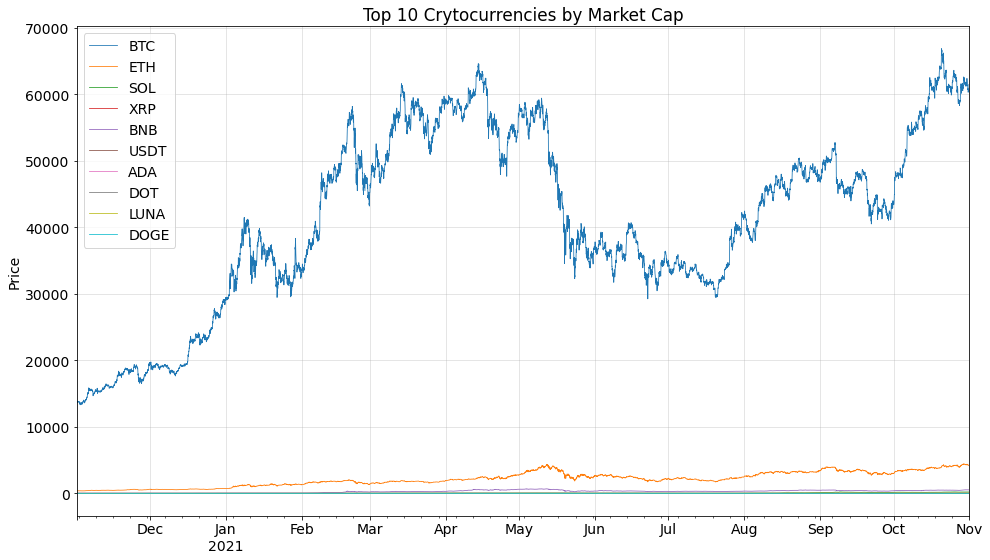

In [51]:
cryptos.plot(linewidth=0.8)
plt.ylabel("Price")
plt.xlabel("")
plt.title("Top 10 Crytocurrencies by Market Cap")
plt.legend(loc='best')
plt.grid(alpha=0.4)
plt.show()

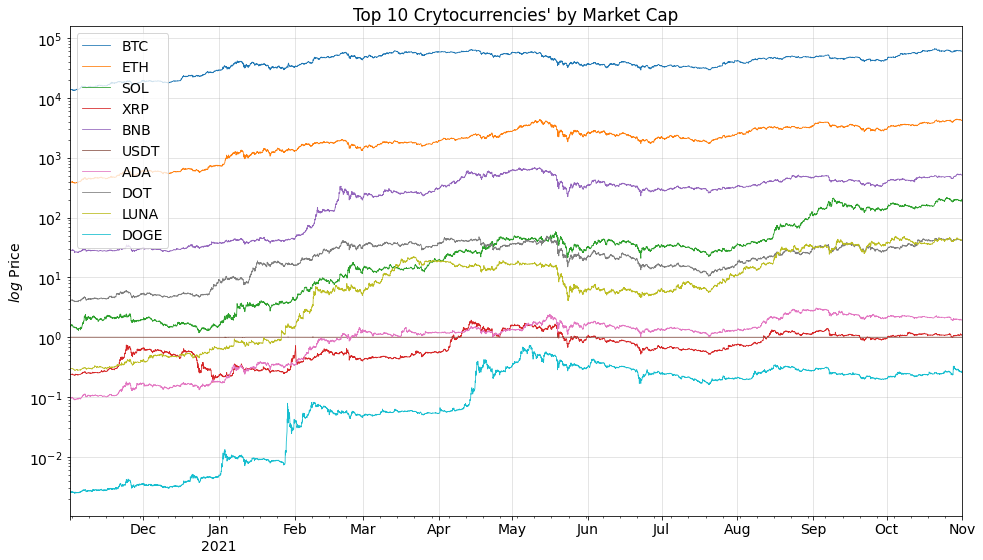

In [52]:
cryptos.plot(linewidth=0.8)
plt.yscale('log')
plt.ylabel("$log$ Price")
plt.xlabel("")
plt.title("Top 10 Crytocurrencies' by Market Cap")
plt.legend(loc='best')
plt.grid(alpha=0.4)
plt.show()

In [40]:
from matplotlib.dates import DateFormatter
plt.rcParams["font.size"] = 14
def plotPriceWithSignal(df):
    # optimze looking later
    plt.plot(df.index,df['price'], c='black')
    #df.loc[:, 'price'].plot()
    buy = df.loc[df['signal']==1, 'price']
    plt.scatter(buy.index, buy, c="green", marker="^", s=150, label="Buy signal")
    sell = df.loc[df['signal']==-1, 'price']
    plt.scatter(sell.index, sell, c="r", marker="v", s=150, label="Sell signal")
    #plt.title("Buy/Sell Signal using CUSUM", fontsize=28, fontname="Times New Roman")
    plt.legend([coin,'Buy Signal','Sell signal'],loc='best', 
               fontsize=16, facecolor='white', frameon=True, edgecolor='0.6', framealpha=80)
    plt.xlabel('')
    plt.ylabel('Price', fontname = 'Times New Roman', fontsize=20)
    plt.yticks(fontsize=13)
    #plt.xticks(np.arange(1,1000,1000))
   
    #set_major_formatter(matplotlib.dates.DateFormatter("%Y"))
    #X = plt.gca().xaxis
   
    # Set the locator
    #locator = mdates.MonthLocator()  # every month
    # Specify the format - %b gives us Jan, Feb...
    #fmt = mdates.DateFormatter('%b')
   
    #X.set_major_locator(locator)
    # Specify formatter
    #X.set_major_formatter(fmt)
    X=plt.gca().xaxis
    date_form = DateFormatter("%H:%M\n%h-%d")
    X.set_major_formatter(date_form)
    plt.grid(alpha=0.4)
    plt.show()

### Generalized CUSUM filter rule

For simplicity, we do not allow short thus we always start by detecting a buy signal. Then we try to detect sell signal after a buy signal.

In [379]:
def trainTestSplit(df):
    df = df.loc[df.index>='2021-05-01', :]
    return df.loc[df.index<'2021-09-01', :], df.loc[df.index>='2021-09-01', :]


def calculateReturn(df, coin: str):
    df.loc[:, "price"] = df.loc[:, coin]
    df.loc[:, "logPrice"] = np.log(df.loc[:, "price"])
    df.loc[:, "return"] = df.loc[:, "logPrice"] - df.loc[:, "logPrice"].shift(1)
    
    df.loc[df.index[0], "return"] = 0
    df.loc[df.index[0], 'signal'] = 0
    cols = ['price', 'logPrice', 'return', 'signal']
    return df.loc[:, cols]


def detectSellSignal(df, start, feature, method, k, h, fee):
    df.loc[df.index[start], 'cMinus'] = 0
    for i in range(start+1, len(df)):
        if method == "montgomery":
            cMinus = np.min([0, -df.loc[df.index[i-1], 'cMinus'] + df.loc[df.index[i], feature]+k])
        else:
            cMinus = np.min([0, df.loc[df.index[i-1], 'cMinus'] + df.loc[df.index[i], feature]-k])
        df.loc[df.index[i], 'cMinus'] = cMinus
        
        if cMinus <= -h:
            # sell signal appears
            df.loc[df.index[i], 'signal'] = -1
            df.loc[df.index[i], 'share'] = 0
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i-1], 'share'] *  df.loc[df.index[i], 'price']
            df.loc[df.index[i], 'equityWithoutFee'] = df.loc[df.index[i], 'equity']
            return detectBuySignal(df, i, feature=feature, method=method, k=k, h=h, fee=fee)
        else:
            df.loc[df.index[i], 'signal'] = 0
            df.loc[df.index[i], 'share'] = df.loc[df.index[i-1], 'share']
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i], 'share'] * df.loc[df.index[i], 'price']
            df.loc[df.index[i], 'equityWithoutFee'] = df.loc[df.index[i], 'equity']
            
    return df


def detectBuySignal(df, start, feature, method, k, h, fee):
    transactionFee = fee
    df.loc[df.index[start], "cPlus"] = 0
    for i in range(start+1, len(df)):
        cPlus = np.max([0, df.loc[df.index[i-1], 'cPlus'] + df.loc[df.index[i], feature]-k])
        df.loc[df.index[i], 'cPlus'] = cPlus
        
        if cPlus >= h:
            # buy signal appears
            df.loc[df.index[i], 'signal'] = 1
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i-1], 'equity'] * (1-transactionFee)
            df.loc[df.index[i], 'equityWithoutFee'] = df.loc[df.index[i-1], 'equity']
            df.loc[df.index[i], 'share'] = df.loc[df.index[i], 'equity'] / df.loc[df.index[i], 'price']
            return detectSellSignal(df, i, feature=feature, method=method, k=k, h=h, fee=fee)
        else:
            df.loc[df.index[i], 'signal'] = 0
            df.loc[df.index[i], 'share'] = df.loc[df.index[i-1], 'share']
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i-1], 'equity']
            df.loc[df.index[i], 'equityWithoutFee'] = df.loc[df.index[i], 'equity']
            
    return df


def createTradeSignal(df, k, h, feature='return', method="montgomery", fee=0.5/100):
    df.loc[df.index[0], 'equity'] = 100
    df.loc[df.index[0], 'share'] = 0
    return detectBuySignal(df, start=0, feature=feature, method=method, k=k, h=h, fee=fee)

In [95]:
def plotPriceWithSignal(df):
#     df.loc[:, 'price'].plot()
    plt.plot(df.index, df.loc[:, 'price'], linewidth=0.9)
    buy = df.loc[df['signal']==1, 'price']
    plt.scatter(buy.index, buy, c="g", marker="^", label="Buy signal")
    sell = df.loc[df['signal']==-1, 'price']
    plt.scatter(sell.index, sell, c="r", marker="v", label="Sell signal")
    plt.ylabel("Price")
    plt.xlabel("")
    plt.grid(alpha=0.4)
    plt.legend(loc='best')
    plt.show()

In [376]:
def plotCUSUM(df, h):
#     df = df.loc[~((df.loc[:,'cPlus']==0)|(df.loc[:,'cMinus']==0)), :]
    plt.plot(df.index,df['cPlus'], linewidth=0.9, color='g', marker='h', markersize=6, label="Detecting buy signal")
    plt.plot(df.index,df['cMinus'], linewidth=0.9, color='r', marker='h', markersize=6, label="Detecting sell signal")
    plt.plot(df.index,np.array([h]*len(df.index)),color='b', label="Control limits")
    plt.plot(df.index,np.array([-h]*len(df.index)),color='b')
    plt.ylabel("CUSUM")
    plt.xlabel("")
    plt.grid(alpha=0.4)
    plt.legend(loc='best')
    plt.show()

## 2. Yi *et al* (2006)

Take transaction fee of each buying and selling into consideration for each trading cycle.

In [22]:
def calculateTransactionFee(df):
    # get trading prices
    buyPrice = df.loc[df['signal']==1, 'price']
    sellPrice = df.loc[df['signal']==-1, 'price']
    buyPriceEven = buyPrice[:len(sellPrice)]

    profitOfEachCycle = []
    for buy, sell in zip(buyPriceEven, sellPrice):
        profitOfEachCycle.append( sell/buy )

    totalProfit = np.prod(profitOfEachCycle)

    buyTime = df.loc[df['signal']==1, :].index
    sellTime = df.loc[df['signal']==-1, :].index
    buyTimeEven = buyTime[:len(sellTime)]

    cycleLength = [] 
    for buy, sell in zip(buyTimeEven, sellTime):
        cycleLength.append(sell - buy)

    totalCycleLength = np.sum(cycleLength) / timedelta(hours=1) # hours
    # average porfit without transaction fee
    averageHourlyProfit = (totalProfit-1) / totalCycleLength

    feeRate = 0.005
    totalProfitWithFee = totalProfit * (1-feeRate)**(2*len(buyTimeEven))
    # average porfit with transaction fee
    averageHourlyProfitWithFee = (totalProfitWithFee-1) / totalCycleLength

    return (totalProfit, totalProfitWithFee,
            averageHourlyProfit, averageHourlyProfitWithFee)

## 3. Žmuk (2016)

Deal with autocorrelation in our data.

### ARIMA(p,d,q)

In [334]:
def applyARIMA(df, coin):
    df.loc[:, "price"] = df.loc[:, coin]
    autoARIMA = auto_arima(df['price'],
                       start_p=0, max_p=5,
                       d=0, max_d=2,
                       start_q=0, max_q=5)
    print("Auto ARIMA parameters: ", autoARIMA.order)
    model = ARIMA(df['price'], order=autoARIMA.order)
    model_fit = model.fit()
    print(model_fit.summary())
    df.loc[:, 'residual'] = model_fit.resid
    return df


def plotBeforeAndAfterARIMA(df):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    autocorrelation_plot(df['price'], label="Price", ax=ax1)
    plt.grid(alpha=0.4)
    autocorrelation_plot(df['residual'], label="Residual", ax=ax2)
    plt.grid(alpha=0.4)
    plt.show()

## 4. Chen and Huang (2012)

### Residual based CUSUM chart

In [158]:
def calculateResidualFeature(df):
    std = np.std(df.loc[:, 'residual'])
    df.loc[:, 'residualFeature'] = df.loc[:, 'residual'] / std
    return df

## 6. Grid Search for k, h

(k, h) for a coin for return/residual CUSUM chart

In [358]:
def getScore(inputdf, coin='', feature='', method='montgomery', fee=0.5/100,
#              kRange=np.arange(0.002, 0.023, step=0.004),#6
             kRange=np.arange(0.02, 0.23, step=0.04),
             hRange=np.arange(0.2, 2.3, step=0.4)):
    if feature == "residualFeature":
        df = (inputdf
              .pipe(applyARIMA, coin)
              .pipe(calculateResidualFeature))
    elif feature == 'return':
        df = (inputdf
              .pipe(calculateReturn, coin))
    elif feature == 'regResidual':
        df = (inputdf
              .pipe(getRegResidual))
    else:
        print("Feature not found!")
    
    outputdf = pd.DataFrame(list(product(kRange, hRange)), columns=['k', 'h'])
    
    for k in kRange:
        for h in hRange:
            trades = createTradeSignal(df, k=k, h=h, feature=feature, method=method, fee=fee)
            kh = (outputdf.loc[:, 'k']==k) & (outputdf.loc[:, 'h']==h)
            outputdf.loc[kh, 'finalEquity'] = trades.equity[-1]
            
    return outputdf.sort_values(by='finalEquity', ascending=False)

In [359]:
def plotScore(df):
    
    plt.subplot(1,2,1)
    plt.scatter(df.loc[:,'k'], df.loc[:,'finalEquity'], label='k')
    plt.ylabel("Final Equity Value")
    plt.xlabel("$k$")
    plt.grid(alpha=0.4)
    plt.subplot(1,2,2)
    plt.scatter(df.loc[:,'h'], df.loc[:,'finalEquity'], label='h')
    plt.ylabel("Final Equity Value")
    plt.xlabel("$h$")
    plt.grid(alpha=0.4)
    plt.show()

## 6.  Backtest

Metrics:

- Start
- End
- Duration
- Average exposure time
- Average waiting time

<!-- - Equity initial: \$1,000,000
- Equity final
- Cumulative Return: 53.01% -->
- Sharpe
- Sortino
- Max Drawdown


In [309]:
def backtest(df):
    # Time
    startTime = df.index[0]
    endTime = df.index[-1]
    duration = endTime - startTime

    buyTime = df.loc[df['signal']==1, :].index
    sellTime = df.loc[df['signal']==-1, :].index
    numberOfCycles = len(sellTime)
    buyTimeEven = buyTime[:numberOfCycles]

    #we bought the coin and hold to find a sell signal
    exposureTime = np.sum(sellTime-buyTimeEven) / numberOfCycles
    waitingTime = ((buyTimeEven[0]-df.index[0]) 
                   + np.sum(buyTimeEven[1:]-sellTime[:-1])) / numberOfCycles


    # Profit
    df.loc[:, 'logEquity'] = np.log(df.loc[:, 'equity'])
    df.loc[:, 'portReturn'] = df.loc[:, 'logEquity'] - df.loc[:, 'logEquity'].shift(1)
    downside = df.loc[:, 'portReturn']<0
    df.loc[downside, 'downsideReturn'] = -df.loc[downside, 'portReturn']
    df.loc[~downside, 'downsideReturn'] = 0

    # Risk
    sharpeRatio = df.loc[:, 'portReturn'].mean() / df.loc[:, 'portReturn'].std()
    sortinoRatio = df.loc[:, 'portReturn'].mean() / df.loc[:, 'downsideReturn'].std()
    df.loc[:, 'drawdown'] = df.loc[:, 'equity'] - df.loc[:, 'equity'].cummax()
    
    return [startTime, endTime, duration, exposureTime, waitingTime, sharpeRatio, sortinoRatio], df

## 7. Risk Adjusted for BioTech Stocks

Adjust biomedical company stock price by biotech indices 

### Price data exploration

- Data
    + Indices
        1. DJI Index: Dow Jones Industrial Average. 30 prominent companies listed on stock exchanges in the United States.
        2. SPX Index: Standard and Poor's 500. 500 large companies listed on stock exchanges in the United States.
        3. **NBI Index**: NASDAQ Biotechnology Index. 213 Biotechnology or the Pharmaceutical industry companies listed on NASDAQ.
        4. **SPSIBI Index**: S&P Biotechnology Select Industry Index. The biotechnology sub-industry portion of the S&P Total Markets Index (S&P TMI).
    + US Equities
        1. PFE US Equity: Pfizer Inc. American multinational pharmaceutical and biotechnology corporation headquartered on 42nd Street in Manhattan, New York City.
        2. **MRNA US Equity**: Moderna Inc.  Pharmaceutical and biotechnology company based in Cambridge, Massachusetts that focuses on RNA therapeutics, primarily mRNA vaccines.
        3. JNJ US Equity:Johnson & Johnson. Consumer Health, Pharmaceutical, and Medical Devices.
        
- Price visualization
    + Data looks clean

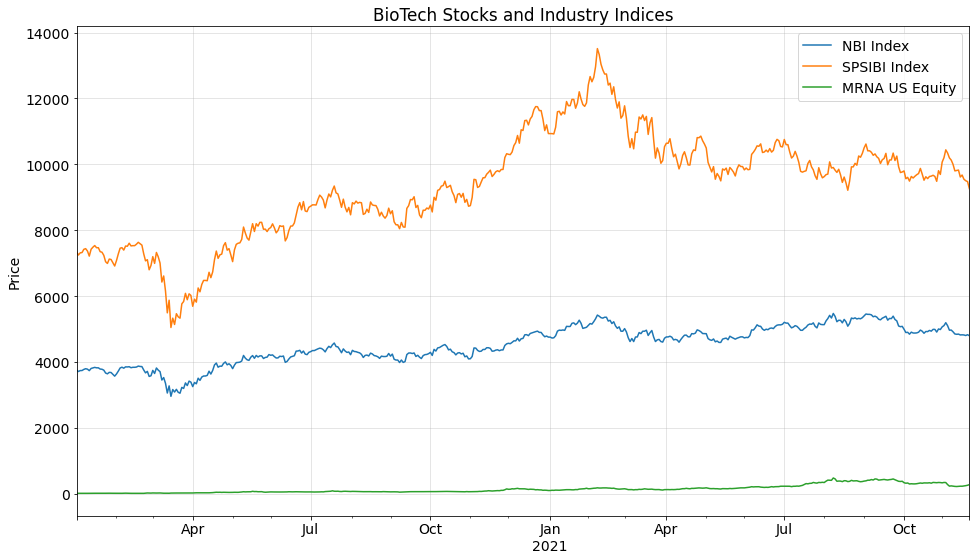

In [310]:
securities = pd.read_excel("../data/biostocks.xlsx", parse_dates=True, index_col="Dates")
securities.loc[:, ['NBI Index', 'SPSIBI Index', 'MRNA US Equity']].plot()
plt.ylabel("Price")
plt.xlabel("")
plt.title("BioTech Stocks and Industry Indices")
plt.legend(loc='best')
plt.grid(alpha=0.4)
plt.show()

In [311]:
equityTicks = ["PFE US Equity", "MRNA US Equity", "JNJ US Equity"]
equities = securities.loc[:, equityTicks]
# equities.plot()
# plt.ylabel("Price")
# plt.xlabel("")
# plt.title("Top 10 Crytocurrencies by Market Cap")
# plt.legend(loc='best')
# plt.grid(alpha=0.4)
# plt.show()

In [312]:
def getRegResidual(df):
    df.loc[:, "price"] = df.loc[:, 'MRNA US Equity']
    X = df.loc[:, ['NBI Index', 'SPSIBI Index']]
    y = df.loc[:, 'MRNA US Equity']
    reg = LinearRegression().fit(X, y)
    prediction = reg.predict(X)
    df.loc[:, 'regResidual'] = y - prediction
    return df

## 8. Plots for methods

Train test split

In [313]:
traindf, testdf = trainTestSplit(cryptos)

coin = 'BTC'

### 8.1 Return CUSUM

1. Fee = 0

In [314]:
returnCusumScoreNoFee = getScore(traindf, coin=coin, feature='return', fee=0)

In [315]:
returnCusumScoreNoFee.head()

,k,h,finalEquity
11,0.0006,0.0044,125.070786
33,0.0022,0.0028,123.893409
22,0.0014,0.0036,123.366604
23,0.0014,0.0044,115.942143
5,0.0002,0.0044,114.155806


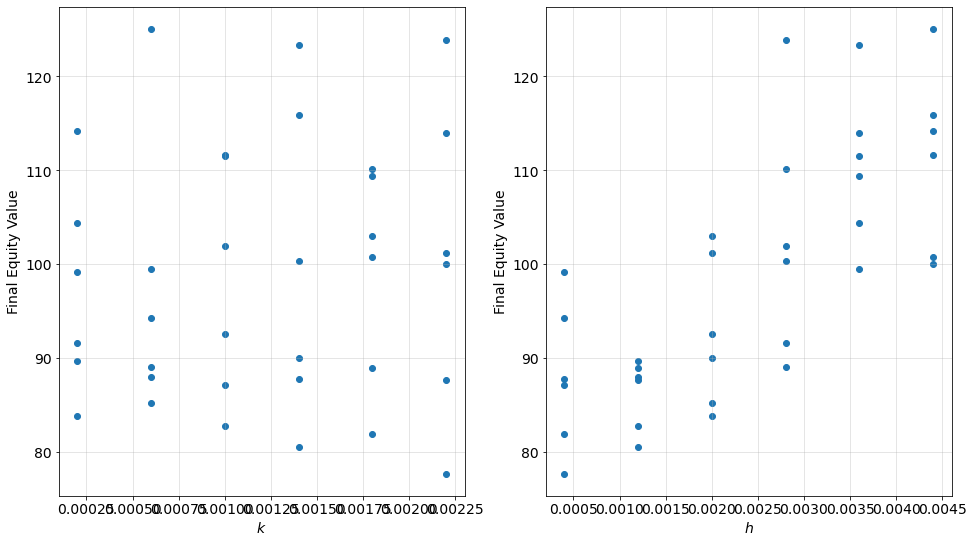

In [316]:
plotScore(returnCusumScoreNoFee)

In [317]:
k = returnCusumScoreNoFee.iloc[0].k
h = returnCusumScoreNoFee.iloc[0].h
print(k, h)

0.0006000000000000001 0.004400000000000001


In [318]:
returnCusumNoFeedf = (testdf
                      .pipe(calculateReturn, coin)
                      .pipe(createTradeSignal, k=k, h=h, fee=0))

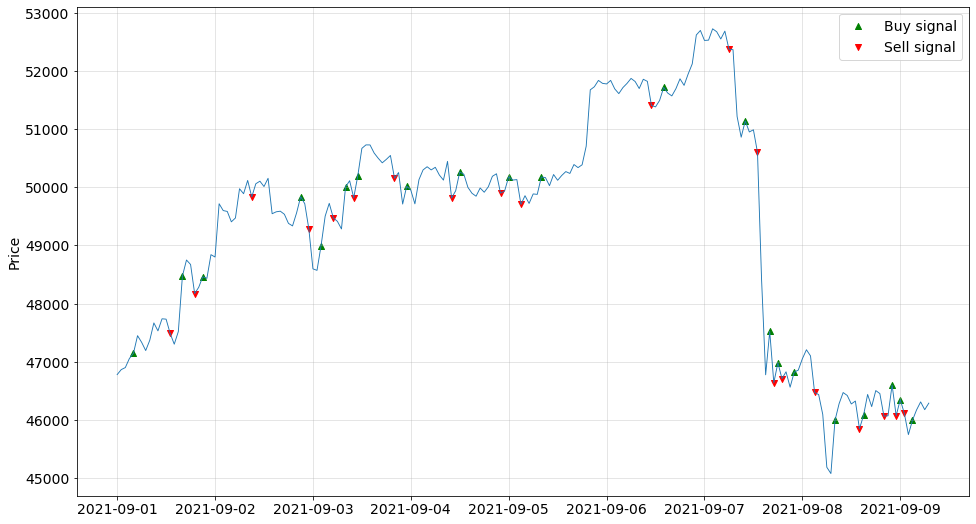

In [319]:
plotPriceWithSignal(returnCusumNoFeedf.head(200))
# Because h is too large, the exposure time (ARL for sell) is too long, so we need to shrink the range of h

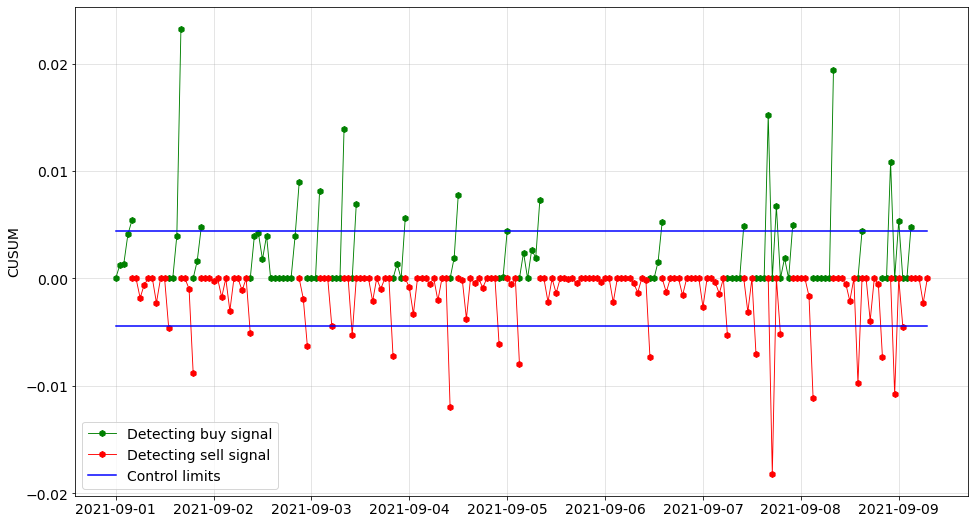

In [320]:
plotCUSUM(returnCusumNoFeedf.head(200), h=h)

In [321]:
returnCusumNoFeedfResult = backtest(returnCusumNoFeedf)
returnCusumNoFeedfResultRatios = returnCusumNoFeedfResult[0]
returnCusumNoFeedfResultdf = returnCusumNoFeedfResult[1]

In [322]:
returnCusumNoFeedfResultdf.head()

,price,logPrice,return,signal,equity,share,cPlus,equityWithoutFee,cMinus,logEquity,portReturn,downsideReturn,drawdown
time,,,,,,,,,,,,,
2021-09-01 00:00:00,46778.94,10.753188,0.000000,0.0,100.0,0.000000,0.000000,NaN,NaN,4.60517,NaN,0.0,0.0
2021-09-01 01:00:00,46864.76,10.755021,0.001833,0.0,100.0,0.000000,0.001233,100.0,NaN,4.60517,0.0,0.0,0.0
2021-09-01 02:00:00,46899.74,10.755767,0.000746,0.0,100.0,0.000000,0.001379,100.0,NaN,4.60517,0.0,0.0,0.0
2021-09-01 03:00:00,47055.59,10.759085,0.003318,0.0,100.0,0.000000,0.004097,100.0,NaN,4.60517,0.0,0.0,0.0
2021-09-01 04:00:00,47146.40,10.761013,0.001928,1.0,100.0,0.002121,0.005425,100.0,0.0,4.60517,0.0,0.0,0.0


In [323]:
returnCusumNoFeedfResultRatios

[Timestamp('2021-09-01 00:00:00'),
 Timestamp('2021-11-01 00:00:00'),
 Timedelta('61 days 00:00:00'),
 Timedelta('0 days 07:05:46.666666666'),
 Timedelta('0 days 03:37:46.666666666'),
 0.00572299298525762,
 0.009358006450682067]

2. Fee = 0.5 \%

In [324]:
returnCusumScore = getScore(traindf, coin=coin, feature='return')

In [325]:
returnCusumScore.head()

,k,h,finalEquity
35,0.0022,0.0044,28.717913
34,0.0022,0.0036,26.897201
23,0.0014,0.0044,26.559938
29,0.0018,0.0044,25.919781
22,0.0014,0.0036,23.832417


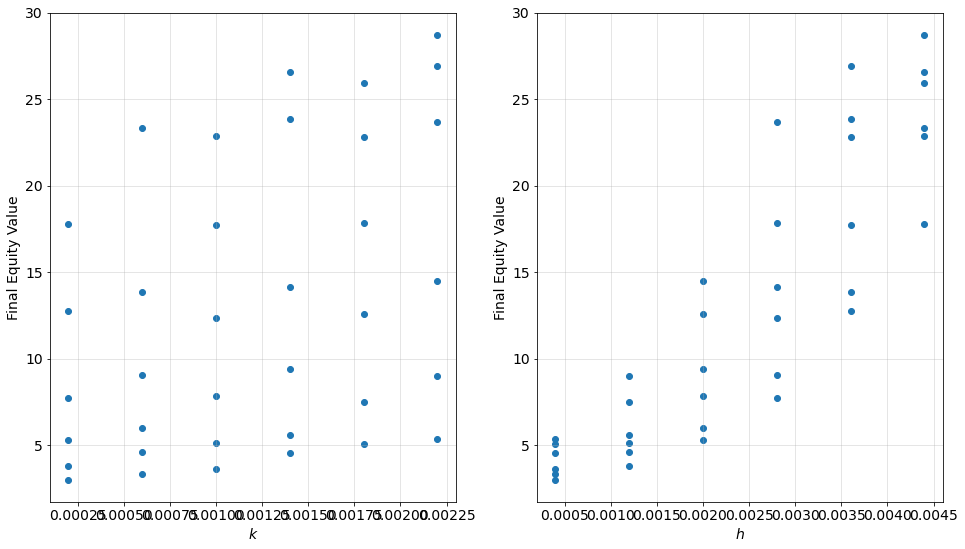

In [326]:
plotScore(returnCusumScore)

In [327]:
k = returnCusumScore.iloc[0].k
h = returnCusumScore.iloc[0].h
print(k, h)

0.0022000000000000006 0.004400000000000001


In [328]:
returnCusumdf = (testdf
                      .pipe(calculateReturn, coin)
                      .pipe(createTradeSignal, k=k, h=h))

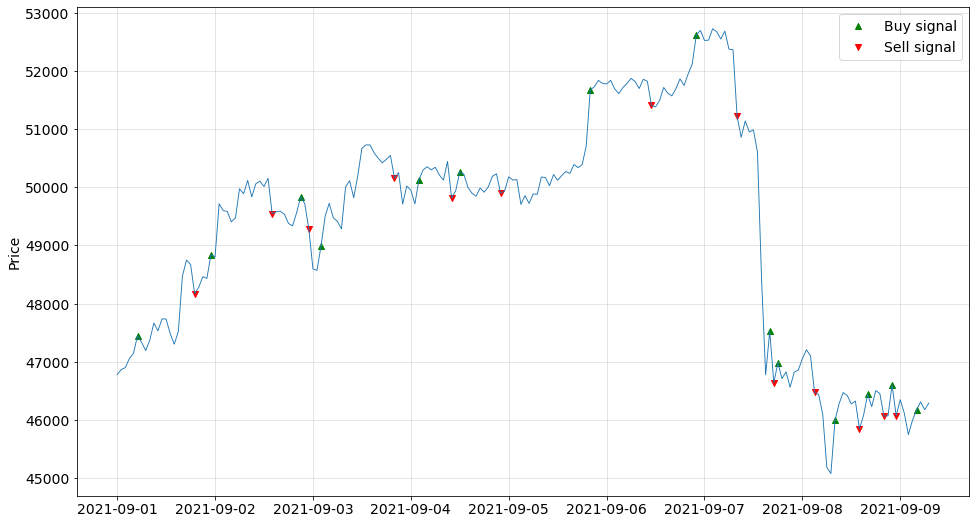

In [329]:
plotPriceWithSignal(returnCusumdf.head(200))
# Because h is too large, the exposure time (ARL for sell) is too long, so we need to shrink the range of h

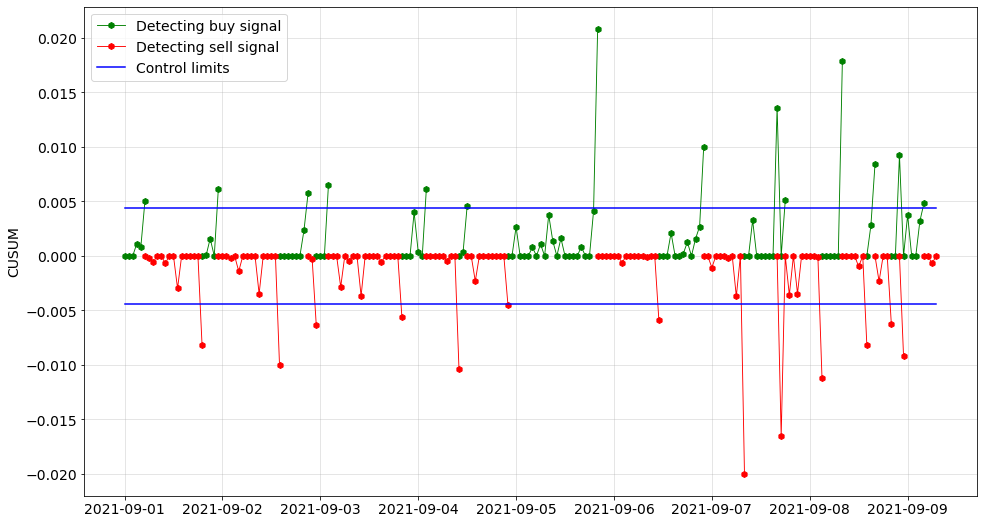

In [330]:
plotCUSUM(returnCusumdf.head(200), h=h)

In [331]:
returnCusumdfResult = backtest(returnCusumdf)
returnCusumdfResultRatios = returnCusumdfResult[0]
returnCusumdfResultdf = returnCusumdfResult[1]
print(returnCusumdfResultRatios)
returnCusumdfResultdf.head()

[Timestamp('2021-09-01 00:00:00'), Timestamp('2021-11-01 00:00:00'), Timedelta('61 days 00:00:00'), Timedelta('0 days 11:11:33.975903614'), Timedelta('0 days 06:15:10.843373493'), -0.04233793553733358, -0.06924501545449693]


,price,logPrice,return,signal,equity,share,cPlus,equityWithoutFee,cMinus,logEquity,portReturn,downsideReturn,drawdown
time,,,,,,,,,,,,,
2021-09-01 00:00:00,46778.94,10.753188,0.000000,0.0,100.0,0.0,0.000000,NaN,NaN,4.60517,NaN,0.0,0.0
2021-09-01 01:00:00,46864.76,10.755021,0.001833,0.0,100.0,0.0,0.000000,100.0,NaN,4.60517,0.0,0.0,0.0
2021-09-01 02:00:00,46899.74,10.755767,0.000746,0.0,100.0,0.0,0.000000,100.0,NaN,4.60517,0.0,0.0,0.0
2021-09-01 03:00:00,47055.59,10.759085,0.003318,0.0,100.0,0.0,0.001118,100.0,NaN,4.60517,0.0,0.0,0.0
2021-09-01 04:00:00,47146.40,10.761013,0.001928,0.0,100.0,0.0,0.000846,100.0,NaN,4.60517,0.0,0.0,0.0


### 8.2 Residual based CUSUM

Auto ARIMA parameters:  (1, 0, 2)
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2952
Model:                 ARIMA(1, 0, 2)   Log Likelihood              -21803.056
Date:                Wed, 01 Dec 2021   AIC                          43616.113
Time:                        23:49:30   BIC                          43646.064
Sample:                    05-01-2021   HQIC                         43626.895
                         - 08-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.067e+04   6625.485      6.139      0.000    2.77e+04    5.37e+04
ar.L1          0.9992      0.001   1209.364      0.000       0.998       1.001
ma.L1          0.0

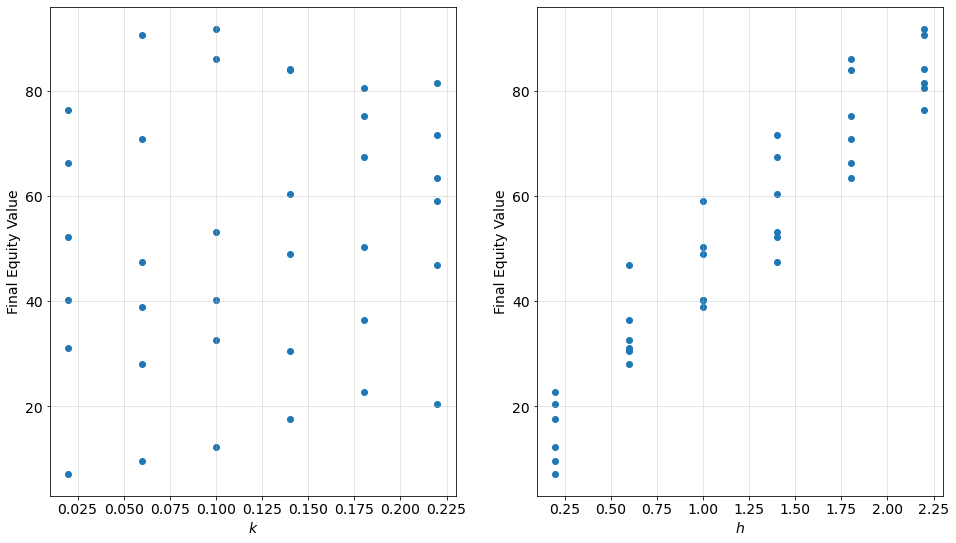

,k,h,finalEquity
17,0.10,2.2,91.771336
11,0.06,2.2,90.646002
16,0.10,1.8,86.014025
23,0.14,2.2,84.202405
22,0.14,1.8,83.983150


In [380]:
residualCusumScore = getScore(traindf, coin=coin, feature='residualFeature')
plotScore(residualCusumScore)
residualCusumScore.head()

In [381]:
k = residualCusumScore.iloc[0].k
h = residualCusumScore.iloc[0].h
print(k, h)

0.09999999999999999 2.2000000000000006


In [382]:
residualCusumdf = (testdf
              .pipe(applyARIMA, coin)
              .pipe(calculateResidualFeature)
      .pipe(createTradeSignal, feature='residualFeature', k=k, h=h))

Auto ARIMA parameters:  (1, 0, 1)
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 1465
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -10701.460
Date:                Wed, 01 Dec 2021   AIC                          21410.921
Time:                        23:50:53   BIC                          21432.079
Sample:                    09-01-2021   HQIC                         21418.813
                         - 11-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.198e+04   9846.454      5.279      0.000    3.27e+04    7.13e+04
ar.L1          0.9992      0.001    855.132      0.000       0.997       1.001
ma.L1         -0.0

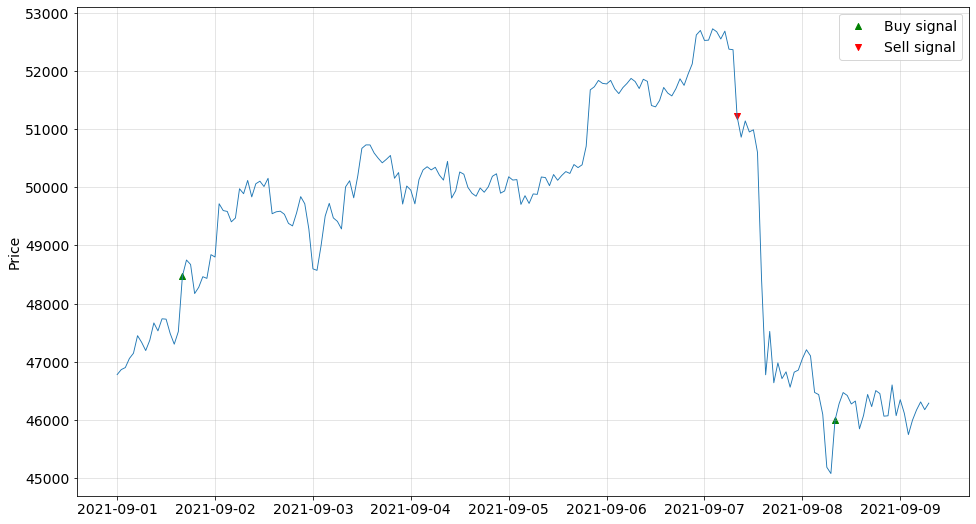

In [383]:
plotPriceWithSignal(residualCusumdf.head(200))

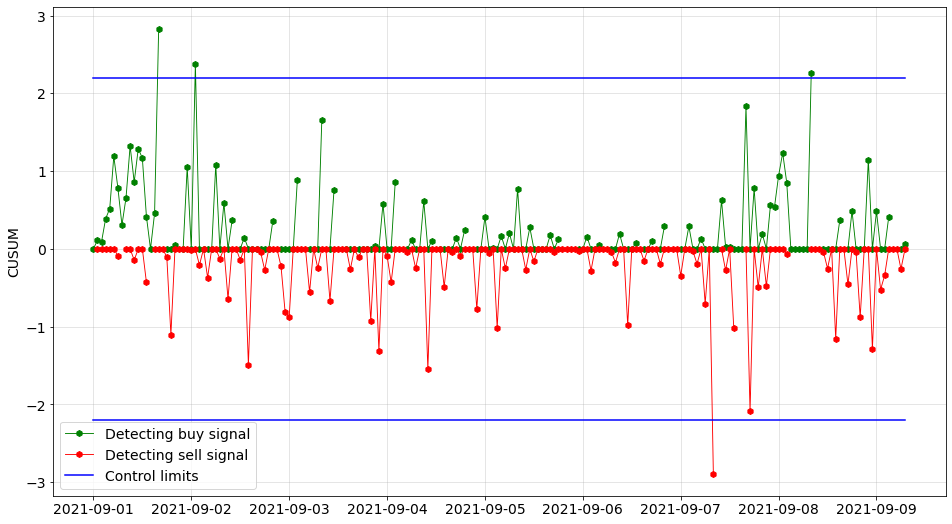

In [384]:
plotCUSUM(residualCusumdf.head(200), h=h)

In [385]:
residualCusumdfResult = backtest(residualCusumdf)
residualCusumdfResultRatios = residualCusumdfResult[0]
residualCusumdfResultdf = residualCusumdfResult[1]
print(residualCusumdfResultRatios)
residualCusumdfResultdf.tail()

[Timestamp('2021-09-01 00:00:00'), Timestamp('2021-11-01 00:00:00'), Timedelta('61 days 00:00:00'), Timedelta('4 days 09:54:32.727272727'), Timedelta('0 days 20:05:27.272727272'), 0.03258664330562509, 0.053462941172749884]


,BTC,ETH,SOL,XRP,BNB,USDT,ADA,DOT,LUNA,DOGE,...,residualFeature,equity,share,cPlus,equityWithoutFee,cMinus,logEquity,portReturn,downsideReturn,drawdown
time,,,,,,,,,,,,,,,,,,,,,
2021-10-31 20:00:00,60969.55,4268.43,198.43,1.102,520.68,1.001,1.959,42.58,42.82,0.2732,...,0.621938,132.790109,0.002178,0.620138,132.790109,0.000000,4.888770,0.003807,0.000000,-15.421271
2021-10-31 21:00:00,61483.09,4308.44,204.40,1.122,524.29,1.000,1.983,43.08,43.20,0.2770,...,1.357021,133.908586,0.002178,NaN,133.908586,0.000000,4.897157,0.008388,0.000000,-14.302794
2021-10-31 22:00:00,61417.06,4296.65,202.20,1.112,525.50,1.001,1.971,42.98,43.19,0.2780,...,-0.151584,133.764774,0.002178,0.000000,133.764774,-0.051584,4.896083,-0.001075,0.001075,-14.446606
2021-10-31 23:00:00,61349.75,4290.10,202.66,1.113,524.94,1.001,1.966,42.77,42.97,0.2802,...,-0.155743,133.618175,0.002178,0.000000,133.618175,-0.004159,4.894986,-0.001097,0.001097,-14.593205
2021-11-01 00:00:00,61603.97,4318.92,208.23,1.130,528.53,1.001,1.974,43.43,43.34,0.2812,...,0.681829,134.171859,0.002178,0.680029,134.171859,0.000000,4.899122,0.004135,0.000000,-14.039521


### 8.3 Return EWMA

### 8.4 Residual based EWMA

### 8.5 Risk ajusted CUSUM

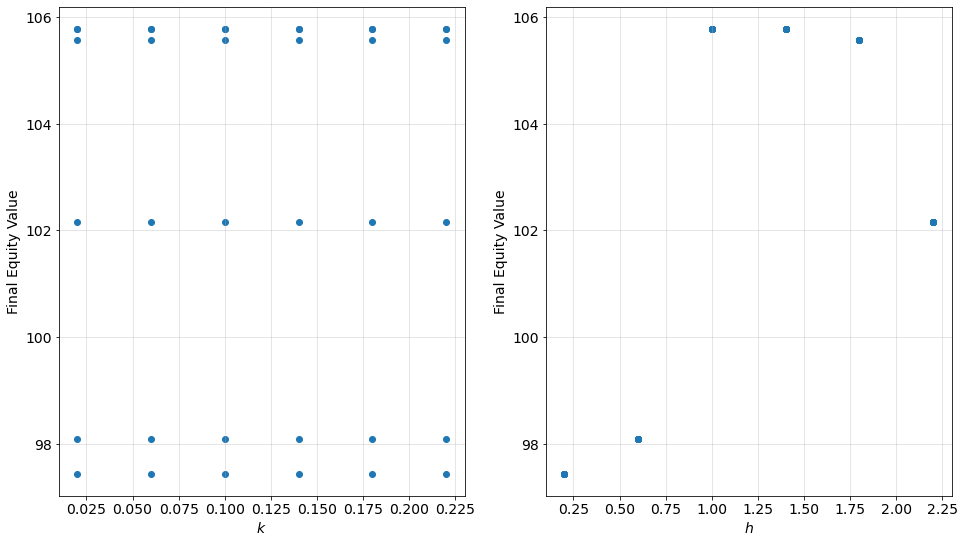

,k,h,finalEquity
15,0.10,1.4,105.779527
8,0.06,1.0,105.779527
14,0.10,1.0,105.779527
32,0.22,1.0,105.779527
33,0.22,1.4,105.779527


In [388]:
stocks = securities.loc[:, ['NBI Index', 'SPSIBI Index', 'MRNA US Equity']]
straindf, stestdf = trainTestSplit(stocks)
raCusumScore = getScore(straindf, feature='regResidual')
plotScore(raCusumScore)
raCusumScore.head()

In [389]:
k = raCusumScore.iloc[0].k
h = raCusumScore.iloc[0].h
print(k, h)

0.09999999999999999 1.4000000000000001


In [391]:
raCusumdf = (stestdf
              .pipe(getRegResidual)
     .pipe(createTradeSignal, k=k, h=h, feature='regResidual'))

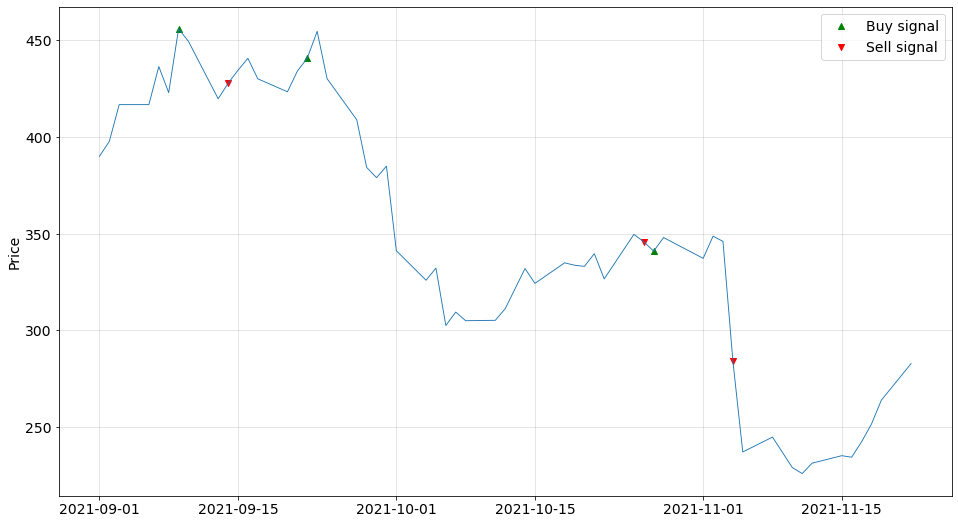

In [392]:
plotPriceWithSignal(raCusumdf.head(200))

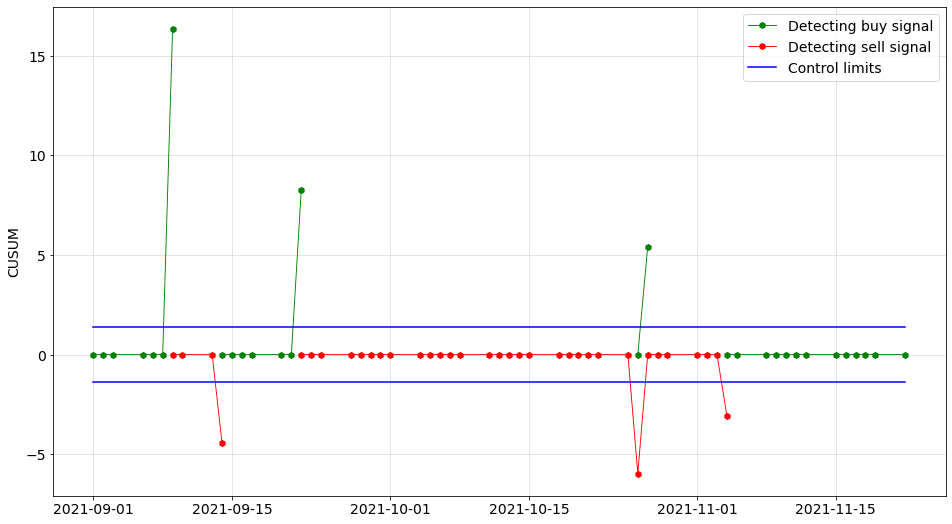

In [393]:
plotCUSUM(raCusumdf.head(200), h=h)

In [395]:
raCusumdfResult = backtest(raCusumdf)
raCusumdfResultRatios = raCusumdfResult[0]
raCusumdfResultdf = raCusumdfResult[1]
print(raCusumdfResultRatios)
raCusumdfResultdf.tail()

[Timestamp('2021-09-01 00:00:00'), Timestamp('2021-11-22 00:00:00'), Timedelta('82 days 00:00:00'), Timedelta('15 days 16:00:00'), Timedelta('5 days 16:00:00'), -0.21851976801953912, -0.2515794762827902]


,NBI Index,SPSIBI Index,MRNA US Equity,price,regResidual,equity,share,cPlus,signal,equityWithoutFee,cMinus,logEquity,portReturn,downsideReturn,drawdown
Dates,,,,,,,,,,,,,,,
2021-11-16,4828.50,9676.96,234.28,234.28,-25.942837,60.403802,0.0,0.0,0.0,60.403802,NaN,4.101052,0.0,0.0,-39.596198
2021-11-17,4824.35,9548.99,242.23,242.23,-37.772903,60.403802,0.0,0.0,0.0,60.403802,NaN,4.101052,0.0,0.0,-39.596198
2021-11-18,4807.69,9503.61,251.41,251.41,-27.850087,60.403802,0.0,0.0,0.0,60.403802,NaN,4.101052,0.0,0.0,-39.596198
2021-11-19,4832.56,9478.35,263.78,263.78,-32.504646,60.403802,0.0,0.0,0.0,60.403802,NaN,4.101052,0.0,0.0,-39.596198
2021-11-22,4800.00,9261.98,282.69,282.69,-33.992884,60.403802,0.0,0.0,0.0,60.403802,NaN,4.101052,0.0,0.0,-39.596198


### 8.6 Risk ajusted EWMA

## 9. Results
Find best models for each coin and backtest on `testdf`.

In [ ]:
stocks = securities.loc[:, ['NBI Index', 'SPSIBI Index', 'MRNA US Equity']]
straindf, stestdf = trainTestSplit(stocks)

coin = "BTC"

df = (traindf
      .pipe(calculateReturn, coin)
      .pipe(createTradeSignal, k=0.005, h=0.005*10)) # , method="46"

In [ ]:
### to delete
# calculate profit
buyPrice = df.loc[df['signal']==1, 'price']
sellPrice = df.loc[df['signal']==-1, 'price']
buyPriceEven = buyPrice[:len(sellPrice)]
np.sum((sellPrice.values-buyPriceEven.values)/buyPriceEven.values)

In [ ]:
def plotPriceWithSignal(df):
    # optimze looking later
    df.loc[:, 'price'].plot()
    buy = df.loc[df['signal']==1, 'price']
    plt.scatter(buy.index, buy, c="g", marker="^", label="Buy signal")
    sell = df.loc[df['signal']==-1, 'price']
    plt.scatter(sell.index, sell, c="r", marker="v", label="Sell signal")
    plt.legend(loc='best')
    plt.show()
    
plotPriceWithSignal(df.head(10000))

In [ ]:
def plotCUSUM(df):
    plt.plot(df.index,df['cPlus'], color='b', marker='h', markersize=6)
    plt.plot(df.index,df['cMinus'], color='r', marker='h', markersize=6)
    plt.plot(df.index,np.array([h]*len(df.index)),color='g')
    plt.plot(df.index,np.array([-h]*len(df.index)),color='g')
    plt.show()
    

plotCUSUM(df.head(100))

Auto ARIMA parameters:  (1, 0, 2)
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2952
Model:                 ARIMA(1, 0, 2)   Log Likelihood              -21803.056
Date:                Wed, 01 Dec 2021   AIC                          43616.113
Time:                        23:16:34   BIC                          43646.064
Sample:                    05-01-2021   HQIC                         43626.895
                         - 08-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.067e+04   6625.485      6.139      0.000    2.77e+04    5.37e+04
ar.L1          0.9992      0.001   1209.364      0.000       0.998       1.001
ma.L1          0.0

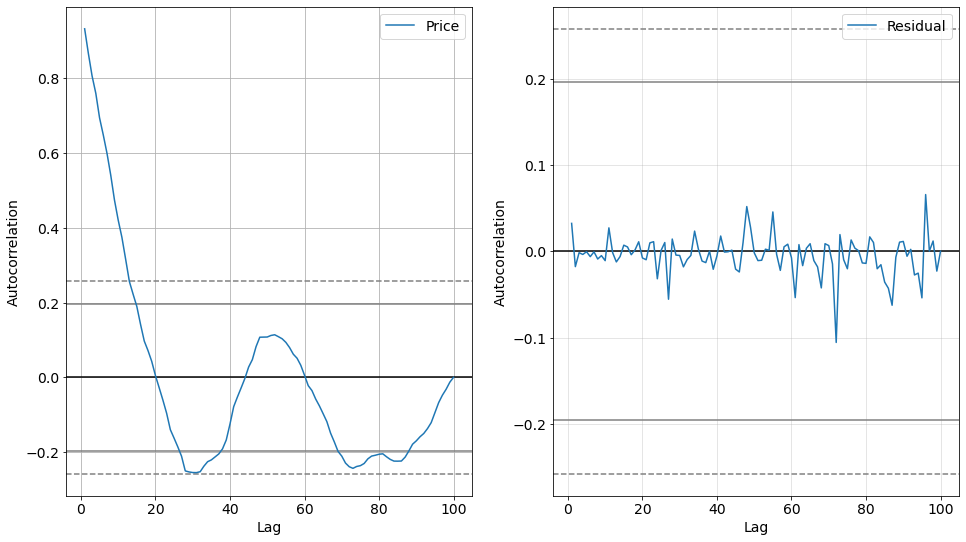

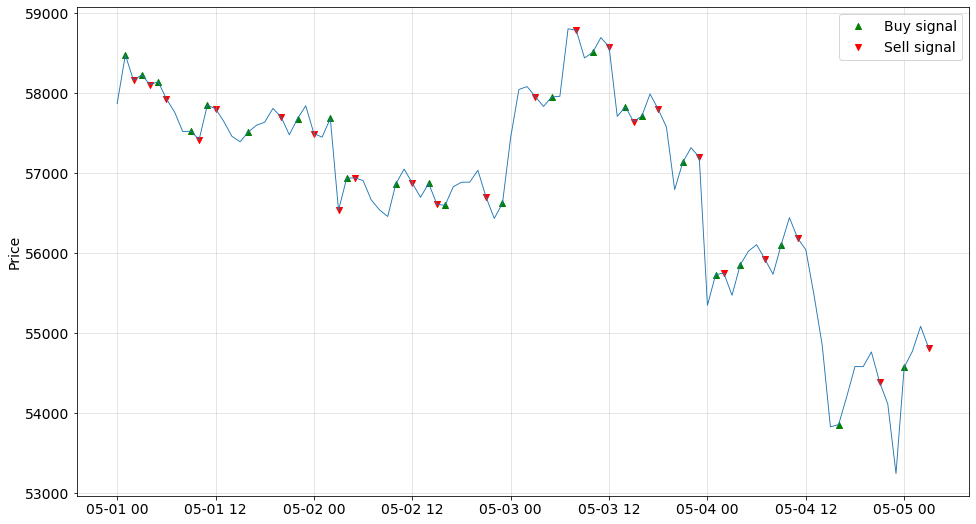

TypeError: plotCUSUM() missing 1 required positional argument: 'h'

In [335]:
coin = "BTC"

df = (traindf
      .pipe(applyARIMA, coin)
      .pipe(calculateResidualFeature)
      .pipe(createTradeSignal, feature='residualFeature', k=k, h=h)
     )

plotBeforeAndAfterARIMA(df.head(100))
plotPriceWithSignal(df.head(100))
plotCUSUM(df.head(100))

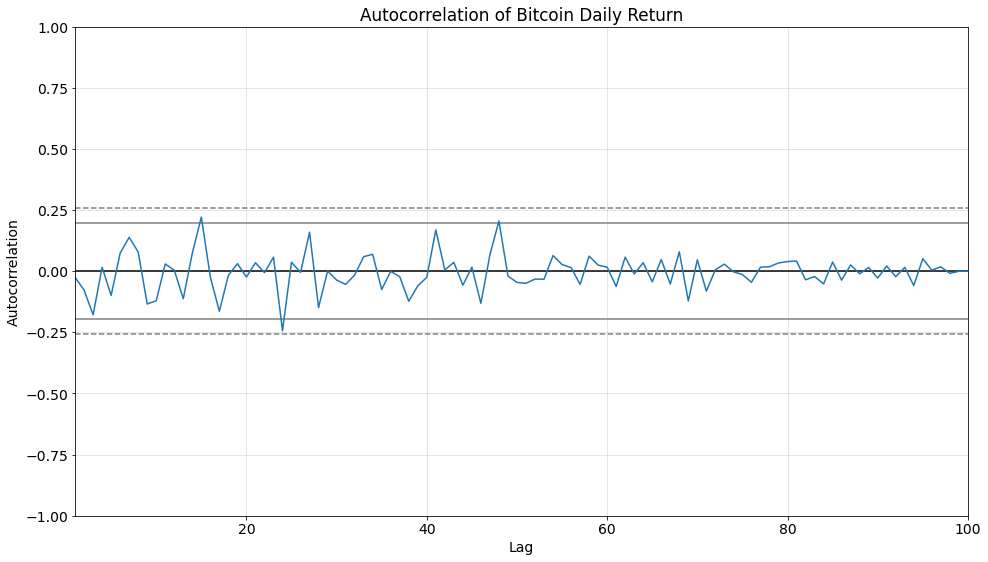

In [175]:
kakk = returnCusumdf.head(100)
autocorrelation_plot(kakk['return'])
plt.title("Autocorrelation of Bitcoin Daily Return")
plt.grid(alpha=0.4)
plt.show()

In [367]:
residualCusumdf.to_csv("../output/www.csv")